## User Tutorial

### Instillation of Dependant Packages

[Anaconda](https://www.continuum.io/) is recommended to create a Python environment within which to use ipymd:

    conda create -n ipymd -c http://conda.binstar.org/gabrielelanaro chemlab matplotlib pandas ipython ipython-notebook pil pyopengl==3.0.2

In [1]:
%matplotlib inline
import ipymd
print ipymd.version()

0.0.2dev


### Basic Atom Creation and Visualisation

The input for a basic atomic visualisation, is a [pandas](http://pandas.pydata.org/) Dataframe that specifies the coordinates, size and color of each atom in the following manner:

In [2]:
import pandas as pd
df = pd.DataFrame(
        [[2,3,4,1,[0, 0, 255],1],
         [1,3,3,1,'orange',1],
         [4,3,1,1,'blue',1]],
        columns=['x','y','z','radius','color','transparency'])

Distances are measured in Angstroms, and colors can be defined in [r,g,b] format (0 to 255) or as a string defined in `available_colors`.

In [3]:
print ipymd.available_colors()['reds']

['light_salmon', 'salmon', 'dark_salmon', 'light_coral', 'indian_red', 'crimson', 'fire_brick', 'dark_red', 'red']


The `Visualise_Sim` class can then be used to setup a visualisation, which is returned in the form of a `PIL` image.

In [4]:
vis = ipymd.visualise_sim.Visualise_Sim()
vis.add_atoms(df)
img1 = vis.get_image()
img1

<PIL.Image._ImageCrop image mode=RGBA size=134x54 at 0x1177C2950>

To convert this into an image viewable in IPython, simply parse it to the `visualise` function.

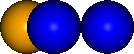

In [5]:
vis.visualise(img1)

Extending this basic procedure, additional objects can be added to the visualisation, the viewpoint can be rotated and multiple images can be output at once, as shown in the following example:

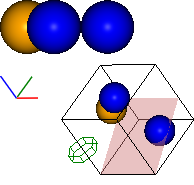

In [6]:
vis.add_axes(length=0.2, offset=(-0.3,0))
vis.add_box([[5,0,0],[0,5,0],[0,0,5]])
vis.add_plane([[5,0,0],[0,5,2]],alpha=0.3)
vis.add_hexagon([[1,0,0],[0,0,.5]],[0,0,2],color='green')

img2 = vis.get_image(xrot=45, yrot=45)
vis.visualise([img1,img2])

### Atom Creation From Other Sources

The `ipymd.data_input` module includes a number of classes to automate the intial creation of the atoms Dataframe, from various sources. Most classes will return a sub-class of `DataInput`, with a `get_atoms` method to return the atoms Dataframe and a `get_simulation_box` method to return the vertexes and origin of the simulation box.

#### Crystal Parameters

This class allows atoms to be created in ordered crystal, as defined by their space group and crystal parameters:

In [7]:
data = ipymd.data_input.crystal.Crystal(
    [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]], ['Na', 'Cl'], 
    225, cellpar=[.54, .54, .54, 90, 90, 90], 
    repetitions=[5, 5, 5])

sim_abc, sim_origin = data.get_simulation_box()
print sim_origin
print sim_abc
atoms_df = data.get_atom_data()
atoms_df.head(2)

[ 0.  0.  0.]
[[  2.70000000e+01   0.00000000e+00   0.00000000e+00]
 [  1.65327318e-15   2.70000000e+01   0.00000000e+00]
 [  1.65327318e-15   1.65327318e-15   2.70000000e+01]]


,id,type,x,y,z,transparency,color,radius
0,1,Na,0.000000e+00,0.0,0.0,1,light_salmon,1
1,2,Na,3.306546e-16,2.7,2.7,1,light_salmon,1


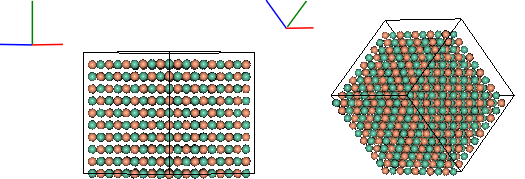

In [8]:
vis2 = ipymd.visualise_sim.Visualise_Sim()
vis2.add_axes()
vis2.add_box(sim_abc, sim_origin)
vis2.add_atoms(atoms_df)
images = [vis2.get_image(xrot=xrot,yrot=45) for xrot in [0,45]]
vis2.visualise(images, columns=2)

A dataframe is available which lists the alternative names for each space group:

In [9]:
df = ipymd.data_input.crystal.get_spacegroup_df()
df.loc[[1,225]]

,System_type,Point group,Short_name,Full_name,Schoenflies,Fedorov,Shubnikov,Fibrifold
Number,,,,,,,,
1,triclinic,1,P1,P 1,$C_1^1$,1s,$(a/b/c)\cdot 1$,-
225,cubic,4/m 3 2/m,Fm3m,F 4/m 3 2/m,$O_h^5$,73s,$\left ( \frac{a+c}{2}/\frac{b+c}{2}/\frac{a+b...,$2^{-}:2$


#### Crystallographic Information Files

.cif files are a common means to store crystallographic data and can be loaded as follows:

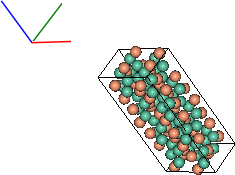

In [10]:
cif_path = ipymd.get_test_path('example_crystal.cif')
data = ipymd.data_input.cif.CIF(cif_path)
vis = ipymd.visualise_sim.Visualise_Sim()
vis.basic_vis(data.get_atom_data(), data.get_simulation_box(),
              xrot=45,yrot=45)

NB: at present, fractional occupancies of lattice sites are returned in the atom Dataframe, but cannot be visualised as such. It is intended that eventually occupancy will be visualised by partial spheres. 

In [11]:
data.get_atom_data().head(1)

,type,x,y,z,occupancy,transparency,color,radius
0,Fe,4.363536,2.40065,22.642804,1,1,light_salmon,1


#### Lammps Input Data

The input data for LAMMPS simulations (supplied to `read_data`) can be input. Note that the `get_atom_data` method requires that the atom_style is defined, in order to define what each data column refers to.

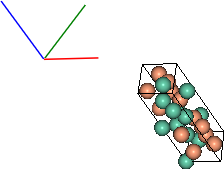

In [12]:
lammps_path = ipymd.get_test_path('lammps_input.data')
data = ipymd.data_input.lammps.LAMMPS_Input(lammps_path)

vis = ipymd.visualise_sim.Visualise_Sim()
vis.basic_vis(data.get_atom_data(atom_style='charge'), data.get_simulation_box(),xrot=45,yrot=45)

#### Lammps Output Data

Output data can be read in the form of a single file or, it is advisable for efficiency, that a single file is output for each timestep, where `*` is used to define the variable section of the filename. The `get_atoms` and `get_simulation_box` methods not take a variable to define which timestep is returned.

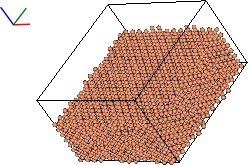

In [13]:
lammps_path = ipymd.get_test_path('atom_onefile.dump')
data = ipymd.data_input.lammps.LAMMPS_Output(lammps_path)

vis = ipymd.visualise_sim.Visualise_Sim()
vis.basic_vis(data.get_atom_data(98), data.get_simulation_box(98),
              spheres=True,xrot=45,yrot=45)

98


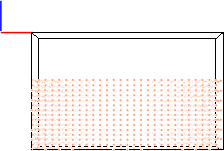

In [14]:
lammps_path = ipymd.get_test_path(['atom_dump','atoms_*.dump'])
data = ipymd.data_input.lammps.LAMMPS_Output(lammps_path)
print data.count_timesteps()

vis = ipymd.visualise_sim.Visualise_Sim()
vis.basic_vis(data.get_atom_data(98), data.get_simulation_box(98),
              spheres=False,xrot=90,yrot=0)

### Atom Manipulation

The atoms Dataframe is already very easy to manipulate using the standard [pandas](http://pandas.pydata.org/) methods. But an `Atom_Manipulation` class has also been created to carry out standard atom manipulations, such as setting variables dependant on atom type or altering the geometry, as shown in this example:

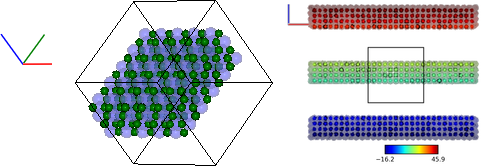

In [15]:
data = ipymd.data_input.crystal.Crystal(
    [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]], ['Na', 'Cl'], 
    225, cellpar=[.54, .54, .54, 90, 90, 90], 
    repetitions=[5, 5, 5])

manipulate_atoms = ipymd.atom_manipulation.Atom_Manipulation

new_df = manipulate_atoms(data.get_atom_data())

new_df.apply_radiimap({'Na':1.5, 'Cl':1})
new_df.apply_colormap({'Na':'blue','Cl':'green'})
new_df.change_type_variable('Na', 'transparency', 0.5)
new_df.slice_z(10,20)

vis2 = ipymd.visualise_sim.Visualise_Sim()
vis2.add_box(*data.get_simulation_box())
vis2.add_axes(offset=(-1.3,-0.7))
vis2.add_atoms(new_df.df, spheres=True)

img1 = vis2.get_image(xrot=45,yrot=45)

vis2.remove_atoms()
new_df.repeat_cell(data.get_simulation_box()[0],((-1,1),(-1,1),(-1,1)))
new_df.color_by_variable('z')
vis2.add_atoms(new_df.df, spheres=True)
img2 = vis2.get_image(xrot=90,yrot=0)
img2 = vis2.draw_colormap(img2,minv=new_df.df.z.min(), maxv=new_df.df.z.max(),
                          bottom=0.05,left=0.52,size=(200,200))

vis2.visualise([img1,img2], columns=2)

NB: the default radii map is by atom  Van der Waals radii (`ipymd.atom_manipulation.vdw_dict`) and the default color map is by the same as in chemlab (`ipymd.atom_manipulation.default_atom_map`).

### Geometric Analysis

Given the simple and flexible form of the atomic data and visualisation, it is now easier to add more complex geometric analysis. These analyses are being contained in the `Atom_Analysis` class, and some initial examples are detailed below:

#### Atomic Coordination

The two examples below show computation of the coordination of Na, w.r.t Cl, in a simple NaCl crystal (which should be 6). The first does not include a consideration of the repeating boundary conditions, and so outer atoms have a lower coordination number. But the latter computation provides a method which takes this into consideration, by repeating the Cl lattice in each direction before computation.

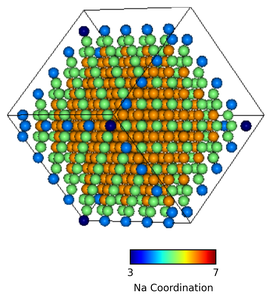

In [31]:
data = ipymd.data_input.crystal.Crystal(
    [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]], ['Na', 'Cl'], 
    225, cellpar=[.54, .54, .54, 90, 90, 90], 
    repetitions=[5, 5, 5])
df = data.get_atom_data()
df['coord'] = 0

analysis = ipymd.atom_analysis.Atom_Analysis()

coord_df = manipulate_atoms(df)
coord_df.filter_variables('Na')

lattice_df = manipulate_atoms(df)
lattice_df.filter_variables('Cl')

na_coord = analysis.calc_coordination(coord_df.df,lattice_df.df)

df.loc[df['type'] == 'Na','coord'] = na_coord

new_df = manipulate_atoms(df)
new_df.filter_variables('Na')
new_df.color_by_variable('coord',minv=3,maxv=7)

vis = ipymd.visualise_sim.Visualise_Sim()
vis.add_box(*data.get_simulation_box())
vis.add_atoms(new_df.df)

img = vis.get_image(xrot=45,yrot=45)
img = vis.draw_colormap(img,minv=3,maxv=7,text='Na Coordination')

vis.visualise(img)

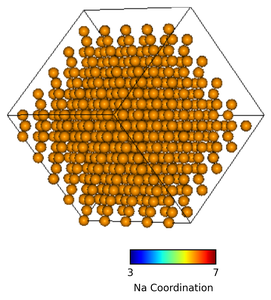

In [17]:
data = ipymd.data_input.crystal.Crystal(
    [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]], ['Na', 'Cl'], 
    225, cellpar=[.54, .54, .54, 90, 90, 90], 
    repetitions=[5, 5, 5])
df = data.get_atom_data()

df = analysis.calc_type_coordination(df, 'Na','Cl',repeat_vectors=data.get_simulation_box()[0])

new_df = manipulate_atoms(df)
new_df.filter_variables('Na')
new_df.color_by_variable('coord_Na_Cl',minv=3,maxv=7)

vis = ipymd.visualise_sim.Visualise_Sim()
vis.add_box(*data.get_simulation_box())
vis.add_atoms(new_df.df)

img = vis.get_image(xrot=45,yrot=45)
img = vis.draw_colormap(img,minv=3,maxv=7,text='Na Coordination')

vis.visualise(img)

#### Atomic Structure Comparison

`compare_to_lattice` takes each atomic coordinate in df1 and computes the distance to the nearest atom (i.e. lattice site) in df2:

In [30]:
import numpy as np
data1 = ipymd.data_input.crystal.Crystal(
    [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]], ['Na', 'Cl'], 
    225, cellpar=[.54, .54, .54, 90, 90, 90], 
    repetitions=[5, 5, 5])
df1 = data1.get_atom_data()

print ('Average distance to nearest atom (identical)', 
       np.mean(analysis.compare_to_lattice(df1,df1)))

data2 = ipymd.data_input.crystal.Crystal(
    [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]], ['Na', 'Cl'], 
    225, cellpar=[.541, .54, .54, 90, 90, 90], 
    repetitions=[5, 5, 5])
df2 = data2.get_atom_data()

print ('Average distance to nearest atom (different)', 
       np.mean(analysis.compare_to_lattice(df1,df2)))


('Average distance to nearest atom (identical)', 0.0)
('Average distance to nearest atom (different)', 0.022499999999999343)


### System Analysis

Within the `LAMMPS_Output` class there is also the option to read in a systems data file, with a log of global variables for each simulation timestep.

In [19]:
data = ipymd.data_input.lammps.LAMMPS_Output(
    sys_path=ipymd.get_test_path('system.dump'))

In [20]:
sys_data = data.get_system_data()
sys_data.tail()

,time,natoms,a,b,vol,press,temp,peng,keng,teng,enth
94,18800,5880,4.000919,4.000920,106961.684112,3984.476256,20.821004,-576758.385663,364.871078,-576393.514586,-570178.024689
95,19000,5880,4.002667,4.002667,107055.104770,3457.822223,20.543535,-576743.788115,360.008650,-576383.779465,-570985.120033
96,19200,5880,3.995696,3.995696,106682.545808,1880.020740,14.949236,-576635.072775,261.973143,-576373.099632,-573448.059018
97,19400,5880,3.990131,3.990134,106385.666301,499.341106,21.315529,-576735.710976,373.537223,-576362.173753,-575587.433134
98,19600,5880,3.979611,3.979609,105825.294988,-2300.315883,17.161320,-576652.409368,300.738098,-576351.671270,-579901.871560


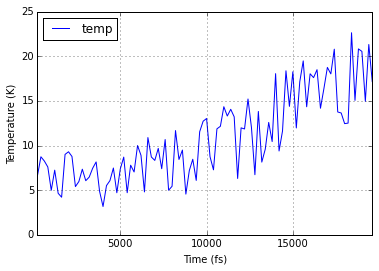

In [21]:
ax = sys_data.plot('time','temp')
ax.set_xlabel('Time (fs)')
ax.set_ylabel('Temperature (K)');
ax.grid()

## TO BE ADDED

(array([[  6.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -3.00000000e+00,   5.19615242e+00,   0.00000000e+00],
       [  7.34788079e-16,   1.27269029e-15,   1.20000000e+01]]), array([ 0.,  0.,  0.]))


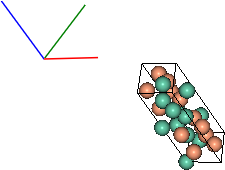

In [33]:
cif_path = ipymd.get_test_path('troilite_p62c.cif')
data = ipymd.data_input.cif.CIF(cif_path)
print data.get_simulation_box(override_abc=[6,6,12])
vis = ipymd.visualise_sim.Visualise_Sim()
vis.basic_vis(data.get_atom_data(override_abc=[6,6,12]), data.get_simulation_box(override_abc=[6,6,12]),
              xrot=45,yrot=45)

In [23]:
atoms_df = data.get_atom_data(override_abc=[6,6,12])
df = ipymd.atom_manipulation.Atom_Manipulation(atoms_df)
df.df.head()

,type,x,y,z,occupancy,transparency,color,radius
0,Fe,2.10990,0.285269,1.47636,1,1,light_salmon,1
1,S,0.00000,0.000000,0.00000,1,1,medium_aquamarine,1
2,S,-0.00003,3.464119,0.23760,1,1,medium_aquamarine,1
3,S,1.00230,5.177966,3.00000,1,1,medium_aquamarine,1
4,Fe,1.69800,3.511560,7.47636,1,1,light_salmon,1


In [24]:
df.translate_atoms([1,1,1])
df.df.head()

,type,x,y,z,occupancy,transparency,color,radius
0,Fe,3.10990,1.285269,2.47636,1,1,light_salmon,1
1,S,1.00000,1.000000,1.00000,1,1,medium_aquamarine,1
2,S,0.99997,4.464119,1.23760,1,1,medium_aquamarine,1
3,S,2.00230,6.177966,4.00000,1,1,medium_aquamarine,1
4,Fe,2.69800,4.511560,8.47636,1,1,light_salmon,1


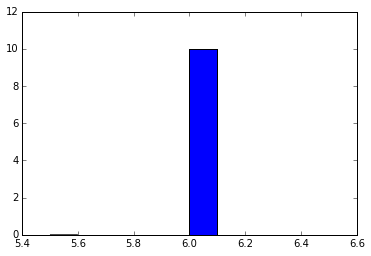

In [23]:
import matplotlib.pyplot as plt
df = data.get_atom_data()
df = analysis.calc_type_coordination(df,'Fe','S',repeat_vectors=data.get_simulation_box()[0])
df[df.type=='Fe'].coord_Fe_S
plt.hist(df[df.type=='Fe'].coord_Fe_S.values,normed=True);

(array([[ 30.4693  ,   0.      ,   0.      ],
       [-15.2347  ,  26.387202,   0.      ],
       [  0.      ,   0.      ,  60.054984]]), array([-0.3221  , -0.279002, -0.634984]))


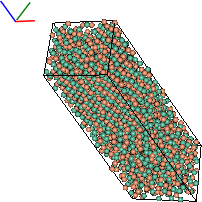

In [24]:
lammps_path = ipymd.get_test_path('thermalized_troilite.dump')
data = ipymd.data_input.lammps.LAMMPS_Output(lammps_path)
print data.get_simulation_box(0)
vis = ipymd.visualise_sim.Visualise_Sim()
vis.basic_vis(data.get_atom_data(0), data.get_simulation_box(0),
              spheres=True,xrot=45,yrot=45)

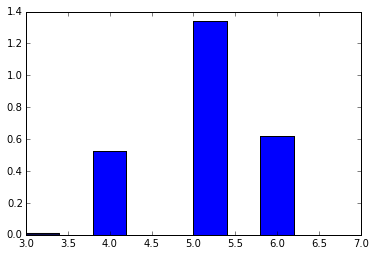

In [25]:
import matplotlib.pyplot as plt
df = data.get_atom_data(0)
df = analysis.calc_type_coordination(df,1,2,repeat_vectors=data.get_simulation_box(0)[0],max_dist=3)
df[df.type==1].coord_1_2
plt.hist(df[df.type==1].coord_1_2.values,normed=True);

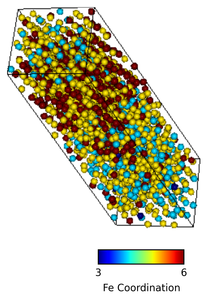

In [26]:
new_df = manipulate_atoms(df)
new_df.filter_variables(1)
new_df.color_by_variable('coord_1_2',minv=3,maxv=6)

vis = ipymd.visualise_sim.Visualise_Sim()
vis.add_box(*data.get_simulation_box(0))
vis.add_atoms(new_df.df)

img = vis.get_image(xrot=45,yrot=45)
img = vis.draw_colormap(img,minv=3,maxv=6,text='Fe Coordination')

vis.visualise(img)

In [5]:
print data.get_atom_timestep(98)
atom_data = data.get_atom_data(98)
sim_abc, sim_origin = data.get_simulation_box(98)
atom_data.head()

9800


,id,type,xs,ys,zs,mass,q,transparency,color,radius
0,259,1,-27.857561,-21.882633,7.196651,55.845,-1.505560e-07,1,light_salmon,1
1,267,1,-27.861259,-25.857124,7.188060,55.845,-2.182330e-07,1,light_salmon,1
2,269,1,-25.863859,-23.880771,7.181207,55.845,-2.916280e-07,1,light_salmon,1
3,271,1,-23.879500,-21.886533,7.184821,55.845,-2.084570e-07,1,light_salmon,1
4,279,1,-25.866796,-27.853247,7.182366,55.845,-1.888220e-07,1,light_salmon,1


In [6]:
print sim_abc
print sim_origin

[[ 55.7146   0.       0.    ]
 [  0.      55.7146   0.    ]
 [  0.       0.      34.092 ]]
[-27.8573 -27.8573   0.    ]


In [7]:
vis = ipymd.visualise_sim.Visualise_Sim()
vis.add_atoms(atom_data,spheres=True)
vis.add_box(sim_abc, sim_origin)
vis.add_axes()
a=vis._atoms[0][0]

In [8]:
vis = ipymd.visualise_sim.Visualise_Sim()
vis.add_atoms(atom_data,spheres=False)
vis.add_box(sim_abc, sim_origin)
vis.add_axes()
b=vis._atoms[0][0]

In [9]:
b=vis._atoms[0][0]

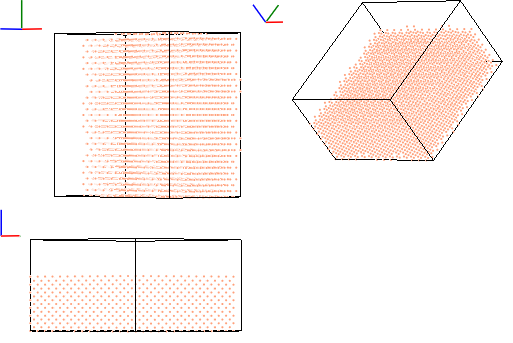

In [10]:
images = [vis.get_image(xrot=xrot,yrot=45) for xrot in [0,45,90]]
vis.visualise(images, columns=2)

In [11]:
df = ipymd.data_input.crystal.get_spacegroup_df()
df.loc[191:194]

,System_type,Point group,Short_name,Full_name,Schoenflies,Fedorov,Shubnikov,Fibrifold
Number,,,,,,,,
191,hexagonal,6/m 2/m 2/m,P6/mmm,P 6/m 2/m 2/m,$D_{6h}^1$,58s,$(c:(a/a))\cdot m:6\cdot m$,-
192,hexagonal,6/m 2/m 2/m,P6/mcc,P 6/m 2/c 2/c,$D_{6h}^2$,48h,$(c:(a/a))\cdot m:6\cdot\tilde c$,-
193,hexagonal,6/m 2/m 2/m,P63/mcm,P 63/m 2/c 2/m,$D_{6h}^3$,87a,$(c:(a/a))\cdot m:6_3\cdot\tilde c$,-
194,hexagonal,6/m 2/m 2/m,P63/mmc,P 63/m 2/m 2/c,$D_{6h}^4$,88a,$(c:(a/a))\cdot m:6_3\cdot m$,-


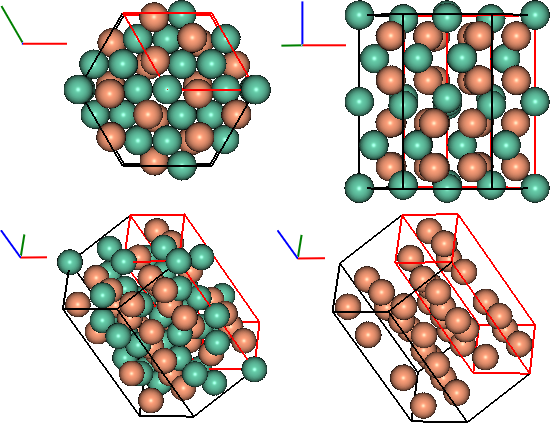

In [13]:
data = ipymd.data_input.lammps.LAMMPS_Input(ipymd.get_test_path('crystal_data.data'))
atom_df = data.get_atom_data('charge')
sim_abc, sim_origin = data.get_simulation_box()

atom_manip = ipymd.atom_manipulation.Atom_Manipulation
new_df = atom_manip(atom_df)
new_df.repeat_cell(sim_abc,repetitions=((-2,2),(-2,2),(-1,1)))
new_df.change_variables({1:'Fe',2:'S'}, vtype='type')
new_df.filter_inside_hexagon(sim_abc[[0,2]], sim_origin)

vis3 = ipymd.visualise_sim.Visualise_Sim()
vis3.add_box(sim_abc,sim_origin,width=2, color='red')
vis3.add_axes(sim_abc, length=0.3,offset=(-0.4,-0.2),width=2)
vis3.add_hexagon(sim_abc[[0,2]],sim_origin, width=2)
vis3.add_atoms(new_df.df)

img1 = vis3.get_image(xrot=0,yrot=0,height=500,width=500)
img2 = vis3.get_image(xrot=90,yrot=0,height=500,width=500)
img3 = vis3.get_image(xrot=45,yrot=45,height=500,width=500)

vis3.remove_atoms()
new_df.filter_variables('Fe', vtype='type')
vis3.add_atoms(new_df.df)
img4 = vis3.get_image(xrot=45,yrot=45,fov=5,height=500,width=500)

#img.save('test.png')
vis3.visualise([img1,img2,img3,img4],columns=2)

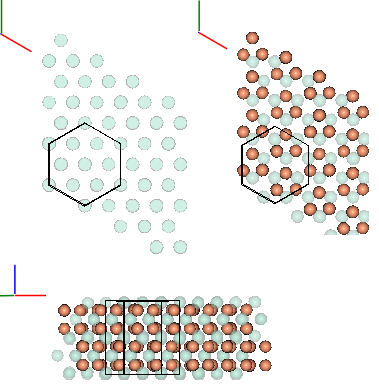

In [14]:
vis3 = ipymd.visualise_sim.Visualise_Sim()

vis3.add_axes(sim_abc,length=0.5,offset=(-0.7,0.1))

new_df = atom_manip(atom_df)
new_df.repeat_cell(sim_abc,repetitions=((-1,2),(-1,2),(0,0)))
new_df.change_variables({1:'Fe',2:'S'})
rep_df = new_df.df

new_df.slice_z(7, 10)
vis3.add_hexagon(sim_abc[[0,2]],sim_origin)

new_df.change_type_variable('S', 'transparency', 0.4)
vis3.add_atoms(new_df.df)

img1 = vis3.get_image(zrot=-30,fov=5)

vis3.remove_atoms()
new_df = atom_manip(rep_df)
new_df.change_variables({1:'Fe',2:'S'})
mid, thick = 5.9, 1.4
new_df.slice_z(mid-thick/2., mid+thick/2.)

new_df.change_type_variable('S', 'transparency', 0.4)
vis3.add_atoms(new_df.df, illustrate=True)

img2 = vis3.get_image(zrot=-30,fov=5)

vis3.remove_atoms()
new_df = atom_manip(rep_df)

new_df.change_type_variable('S', 'transparency', 0.4)
vis3.add_atoms(new_df.df)

img3 = vis3.get_image(xrot=90)

vis3.visualise([img2, img1, img3],columns=2)

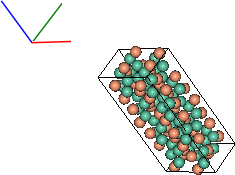

In [15]:
data = ipymd.data_input.cif.CIF(ipymd.get_test_path('example_crystal.cif'))
vis = ipymd.visualise_sim.Visualise_Sim()
vis.basic_vis(data.get_atom_data(), data.get_simulation_box(),xrot=45,yrot=45)

360.910673814 2.92277307527


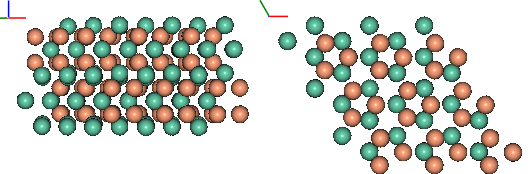

In [16]:
data = ipymd.data_input.crystal.Crystal(
    [[0.37910,   0.05490,   0.12303],
    [0.00000,   0.00000,   0.00000],
    [0.33333,   0.66667,   0.01980],
    [0.66530,  -0.00350,   0.25000]], 
    ['Fe','S','S','S'],
    190, cellpar=[.5958, .5958, 1.174, 90, 90, 120],
    mass_map={'Fe':55.8450,'S':32.06})
sim_abc, sim_origin = data.get_simulation_box()

analysis = ipymd.atom_analysis.Atom_Analysis(data.get_atom_data(), sim_abc)
print analysis.calc_volume(), analysis.calc_density()

atoms = ipymd.atom_manipulation.Atom_Manipulation(data.get_atom_data())
atoms.repeat_cell(sim_abc, repetitions=(2,2,0))
atoms.filter_inside_box

vis = ipymd.visualise_sim.Visualise_Sim()
#vis.add_box(sim_abc, sim_origin)
vis.add_axes(sim_abc, length=0.2,offset=(-0.2,0.1))

vis.add_atoms(atoms.df)
img1 = vis.get_image(xrot=90, yrot=0,fov=5)

vis.remove_atoms()
atoms.slice_z(2,5)

new_df.change_type_variable('S', 'transparency', 0.4)
vis.add_atoms(atoms.df)
img2 = vis.get_image(xrot=0, yrot=0,fov=5)

vis.visualise([img1,img2],columns=2)

2846.26763781


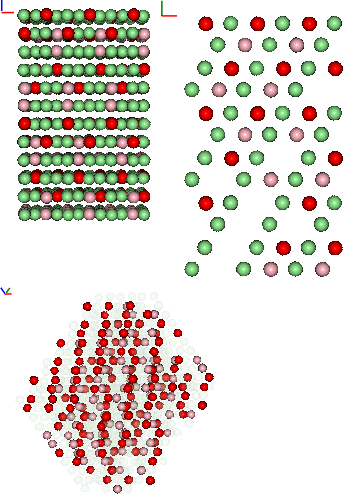

In [18]:
data = ipymd.data_input.cif.CIF(ipymd.get_test_path('/Users/cjs14/Downloads/AMS_DATA(7).cif'), ignore_overlaps=True)
sim_abc, sim_origin = data.get_simulation_box()

analysis = ipymd.atom_analysis.Atom_Analysis(data.get_atom_data(), sim_abc)
print analysis.calc_volume()

df = data.get_atom_data()
df.loc[(df['type']=='Fe'),'color'] = 'light_green'
df.loc[(df['type']=='Fe') & (df.occupancy < 1),'color'] = 'red'
df.loc[(df['type']=='Fe') & (df.occupancy < 0.75),'color'] = 'light_pink'

atoms = ipymd.atom_manipulation.Atom_Manipulation(df)
atoms.repeat_cell(sim_abc, repetitions=(2,2,0))
#atoms.filter_inside_box
atoms.filter_variables(['Fe'])

vis = ipymd.visualise_sim.Visualise_Sim()
#vis.add_box(sim_abc, sim_origin)
vis.add_axes(sim_abc, length=0.2,offset=(-0.4,0.1))

vis.add_atoms(atoms.df)
img1 = vis.get_image(xrot=90, yrot=0,fov=5)

vis.remove_atoms()
#atoms.slice_z(0,2)
atoms.slice_z(2,5)
df = atoms.df
import random
vis.add_atoms(df[df['occupancy'].apply(lambda x: 0 if random.random()>x else 1)==1])
img2 = vis.get_image(xrot=0, yrot=0,fov=5)

vis.remove_atoms()
atoms.undo_last()
df = atoms.df
df.loc[(df['type']=='Fe') & (df.occupancy == 1),'transparency'] = 0.1


vis.add_atoms(df[df['occupancy'].apply(lambda x: 0 if random.random()>x else 1)==1])
img3 = vis.get_image(xrot=45, yrot=45,fov=5)

vis.visualise([img1,img2,img3],columns=2)

In [35]:
from fractions import gcd
df = data.get_atom_data()
s,fe = df[df['type']=='S'].shape[0], df[df['type']=='Fe'].shape[0]
print 'Fe_{0}S_{1}'.format(fe/gcd(s,fe), s/gcd(s,fe))

Fe_4S_3


In [136]:
new = df[df['occupancy'].apply(lambda x: 0 if random.random()>x else 1)==1]
s,fe = new[new['type']=='S'].shape[0], new[new['type']=='Fe'].shape[0]
print fe/float(s)
print 'Fe_{0}S_{1}'.format(fe/gcd(s,fe), s/gcd(s,fe))

1.11458333333
Fe_107S_96


In [147]:
df.shape[0]

260